In [14]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os
from PIL import Image
import nibabel as nib
import glob
from transformers import pipeline
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np


In [4]:
data_dir = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/shared/brain_age/'
meta_data = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data.head()
images_2d = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_images/x_axis/'
os.makedirs(images_2d, exist_ok = True)

In [6]:
for i in range(0, len(meta_data['subject_id'])):
    img =sitk.ReadImage(data_dir + 'images/sub-' + meta_data['subject_id'][i]+ '_T1w_unbiased.nii.gz')
    img_array = sitk.GetArrayFromImage(img)
    mask =sitk.ReadImage(data_dir + 'masks/sub-' + meta_data['subject_id'][i]+ '_T1w_brain_mask.nii.gz')
    mask_array = sitk.GetArrayFromImage(img)
    
    x = int(img.GetSize()[0]/2)
    y = int(img.GetSize()[1]/2)
    z = int(img.GetSize()[2]/2)

    top_slice = img[z,:,:]
    back_slice = img[:,y,:]
    front_slice = img[:,:,x]


    top_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_images/x_axis/'
    back_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_images/y_axis/'
    front_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_images/z_axis/'

    sitk.WriteImage(top_slice, top_slice_path + meta_data['subject_id'][i] + '.nii.gz')
    sitk.WriteImage(back_slice, back_slice_path + meta_data['subject_id'][i] + '.nii.gz')
    sitk.WriteImage(front_slice, front_slice_path + meta_data['subject_id'][i] + '.nii.gz')

In [8]:
import matplotlib.pyplot as plt
for i in range(0, len(meta_data['subject_id'])):
    mask =sitk.ReadImage(data_dir + 'masks/sub-' + meta_data['subject_id'][i]+ '_T1w_brain_mask.nii.gz')
    
    x = int(mask.GetSize()[0]/2)
    y = int(mask.GetSize()[1]/2)
    z = int(mask.GetSize()[2]/2)

    top_slice = mask[z,:,:]
    back_slice = mask[:,y,:]
    front_slice = mask[:,:,x]

    top_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_masks/x_axis/'
    back_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_masks/y_axis/'
    front_slice_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_masks/z_axis/'

    sitk.WriteImage(top_slice, top_slice_path + meta_data['subject_id'][i] + '_brain_mask.nii.gz')
    sitk.WriteImage(back_slice, back_slice_path + meta_data['subject_id'][i] + '_brain_mask.nii.gz')
    sitk.WriteImage(front_slice, front_slice_path + meta_data['subject_id'][i] + '_brain_mask.nii.gz')

In [13]:
#Converting Images to PNG format for Zero-Shot Segmentation.
images_2d_path = r'C:/Users/aksha/Desktop/opn_ml_final_project/inputs/2d_images/y_axis/'
extension = '*.nii.gz'
search_path = images_2d_path + extension

nii_files = glob.glob(search_path)
for file in nii_files:
    nii_data = nib.load(file) # load the file as a nibabel object
    png_image = Image.fromarray(nii_data.get_fdata())
    png_image = png_image.convert('L')
    png_image.save(file+'.png') 


In [20]:
#Utils for zero shot
def display_mask(mask, axis, use_random_color=False):
    if use_random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    
    height, width = mask.shape[-2:]
    mask_image = mask.reshape(height, width, 1) * color.reshape(1, 1, -1)
    axis.imshow(mask_image)
    del mask
    gc.collect()

def display_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    axis = plt.gca()
    axis.set_autoscale_on(False)
    
    for mask in masks:
        display_mask(mask, axis=axis, use_random_color=True)
    
    plt.axis("off")
    plt.show()
    del masks
    gc.collect()

In [17]:
#Zero Shot Segmentation
generator = pipeline("mask-generation", model="facebook/sam-vit-huge")
img = r"inputs\2d_images\y_axis\CC110033.nii.gz.png"
img = Image.open(img)
outputs = generator(img)

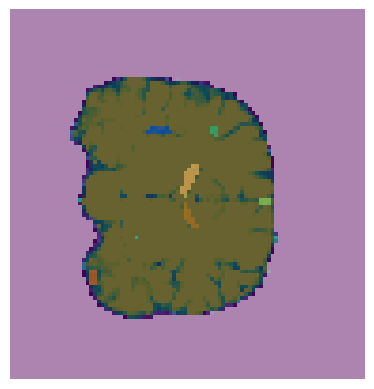

No of Segments - 11


In [24]:
masks = outputs["masks"]
display_masks_on_image(img, masks)
print('No of Segments -', len(outputs['masks']))